# 20Newsgroup data

## Introduction

In this notebook, we will demonstrate how to use the following functions on the 20Newsgroup data
- `matrix_from_text()`
- `WassersteinDimensionSelect()`
- `embed()`
- `plot_dendrogram()`
- `plot_HC_clustering()`

Each document is associated with 1 of 20 newsgroup topics, organized at two
hierarchical levels.

In [ ]:
# ## change working directory to the root of the project  
# import os   
# os.chdir("../../..") 

# import os
# ## show working directory   
# print(os.getcwd())

In [5]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import pyemb as eb

## Data load

Import data and create dataframe.

In [6]:
newsgroups = fetch_20newsgroups() 

df = pd.DataFrame()
df["data"] = newsgroups["data"]
df["target"] = newsgroups["target"]
df["target_names"] = df.target.apply(
    lambda row: newsgroups["target_names"][row])
df[['layer1', 'layer2']] = df['target_names'].str.split('.', n=1, expand=True)

In [7]:
df.head()

,data,target,target_names,layer1,layer2
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,rec,autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,comp,sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware,comp,sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,comp,graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,sci,space


For a random sample of the data, create tf-idf features.

In [8]:
n = 5000
df = df.sample(n=n, replace=False, random_state=22).reset_index(drop=True)

`eb.'text_matrix_and_attributes' - creates a Y matrix of tf-idf features. It takes in a dataframe and the column which contains the data. Further functionality includes: removing general stopwords, adding stopwords, removing email addresses, cleaning (lemmatize and remove symbol, lowercase letters) and a threshold for the min/max number of documents a word needs to appear in to be included.

In [35]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from re import sub, compile
from textblob import Word

def _ensure_stopwords_downloaded():
    try:
        nltk.data.find("corpora/stopwords")
    except LookupError:
        nltk.download("stopwords")
        
def _del_email_address(text):
    """
    Not used by user."""
    e = "\S*@\S*\s?"
    pattern = compile(e)
    return pattern.sub("", text)


def _clean_text_(text):
    """
    Not used by user."""
    return " ".join(
        [
            Word(word).lemmatize()
            for word in sub("[^A-Za-z0-9]+", " ", text).lower().split()
        ]
    )


def text_matrix_and_attributes(
    data,
    column_name,
    remove_stopwords=True,
    clean_text=True,
    remove_email_addresses=False,
    update_stopwords=None,
    **kwargs,
):
    """
    Create a matrix from a column of text data.

    Parameters
    ----------
    data : pandas.DataFrame
        The data to be used to create the matrix.
    column_name : str
        The name of the column containing the text data.
    remove_stopwords : bool
        Whether to remove stopwords.
    clean_text : bool
        Whether to clean the text data.
    remove_email_addresses : bool
        Whether to remove email addresses.
    update_stopwords : list of str
        The list of additional stopwords to be removed.
    kwargs : dict
        Other arguments to be passed to sklearn.feature_extraction.text.TfidfVectorizer.

    Returns
    -------
    Y : numpy.ndarray
        The matrix created from the text data.
    attributes : list of lists
        The attributes of the nodes. The first list contains the attributes
        of the nodes in rows. The second list contains
        the attributes of the nodes in the columns.
    """

    _ensure_stopwords_downloaded()

    # gets rid of email addresses  in data
    if remove_email_addresses:
        data[column_name] = data[column_name].apply(_del_email_address)

    if clean_text:
        # gets rid of stopwords, symbols, makes lower case and base words
        data[column_name] = data[column_name].apply(_clean_text_)

    if remove_stopwords:
        stopwords = set(nltk.corpus.stopwords.words("english"))
        if update_stopwords:
            stopwords.update(update_stopwords)
    else:
        stopwords = None

    # make matrix from text using TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words=list(stopwords), **kwargs)
    Y = vectorizer.fit_transform(data[column_name])

    # attributes
    row_attrs = [{"document": i} for i in data.index]
    col_attrs = [{"term": i} for i in vectorizer.get_feature_names_out()]

    return Y, [row_attrs, col_attrs]

In [36]:
Y, attributes = text_matrix_and_attributes(df, 'data', remove_stopwords=True, clean_text=True,
                                    remove_email_addresses=True, update_stopwords=['subject'],
                                    min_df=5, max_df=len(df)-1000)

In [37]:
(n,p) = Y.shape
print("n = {}, p = {}".format(n,p))

n = 5000, p = 12795


Perform dimension selection using Wasserstein distances, see [^1] for details

In [52]:
from tqdm import tqdm
import numpy as np
from scipy import sparse
import logging


def wasserstein_dimension_select(Y, dims, split=0.5):
    """
    Select the number of dimensions using Wasserstein distances.

    Parameters
    ----------
    Y : numpy.ndarray
        The array of matrices.
    dims : list of int
        The dimensions to be considered.
    split : float
        The proportion of the data to be used for training.

    Returns
    -------
    ws : list of numpy.ndarray
        The Wasserstein distances between the training and test data for each number of dimensions. The dimension recommended is the one with the smallest Wasserstein distance.
    """

    try:
        import ot
    except ModuleNotFoundError:
        logging.error("ot not found, please install ot package with 'pip install pot'")

    n = Y.shape[0]
    idx = np.random.choice(range(n), int(n * split), replace=False)
    Y1 = Y[idx]

    mask = np.ones(Y.shape[0], dtype=bool)
    mask[idx] = False
    Y2 = Y[mask]

    if sparse.issparse(Y2):
        Y2 = Y2.toarray()
    n1 = Y1.shape[0]
    n2 = Y2.shape[0]
    max_dim = np.max(dims)
    U, S, Vt = sparse.linalg.svds(Y1, k=max_dim)
    S = np.flip(S)
    Vt = np.flip(Vt, axis=0)
    Ws = []
    for dim in tqdm(dims):
        M = ot.dist((Y1 @ Vt.T[:, :dim]) @ Vt[:dim, :], Y2, metric="euclidean")
        Ws.append(ot.emd2(np.repeat(1 / n1, n1), np.repeat(1 / n2, n2), M))

    print(f"Recommended dimension: {np.argmin(Ws)}, Wasserstein distance {Ws[dim]:.5f}")
    return Ws

In [44]:
ws = wasserstein_dimension_select(Y, range(40), split=0.5)
dim = np.argmin(ws)

100%|██████████| 40/40 [02:32<00:00,  3.82s/it]


In [53]:
print("Selected dimension: {}".format(dim))

Selected dimension: 32


## PCA and tSNE

Now we perform PCA [^1].

In [54]:
zeta = p**-.5 * eb.embed(Y, dim, version='full')

Apply t-SNE

In [55]:
from sklearn.manifold import TSNE

tsne_zeta = TSNE(n_components=2, perplexity=30).fit_transform(zeta)

Make dataframes of PCA embedding and t-SNE embedding for plotting

In [56]:
zeta_df = pd.DataFrame(zeta[:, :2])
zeta_df["target"] = np.array(df['target_names'])
targets = zeta_df["target"].unique()
targets = sorted(targets)
labels = df['target']

tsne_zeta_df = pd.DataFrame(tsne_zeta)
tsne_zeta_df["target"] = np.array(df['target_names'])
targets = tsne_zeta_df["target"].unique()
targets = sorted(targets)

Colours dictionary where topics from the same theme have different shades of the same colour

In [57]:
target_colour = {'alt.atheism': 'goldenrod',
                 'comp.graphics': 'steelblue',
                 'comp.os.ms-windows.misc': 'skyblue',
                 'comp.sys.ibm.pc.hardware': 'lightblue',
                 'comp.sys.mac.hardware': 'powderblue',
                 'comp.windows.x': 'deepskyblue',
                 'misc.forsale': 'maroon',
                 'rec.autos': 'limegreen',
                 'rec.motorcycles': 'green',
                 'rec.sport.baseball': 'yellowgreen',
                 'rec.sport.hockey': 'olivedrab',
                 'sci.crypt': 'pink',
                 'sci.electronics': 'plum',
                 'sci.med': 'orchid',
                 'sci.space': 'palevioletred',
                 'soc.religion.christian': 'darkgoldenrod',
                 'talk.politics.guns': 'coral',
                 'talk.politics.mideast': 'tomato',
                 'talk.politics.misc': 'darksalmon',
                 'talk.religion.misc': 'gold'}

Plot PCA on the LHS and PCA + t-SNE on the RHS

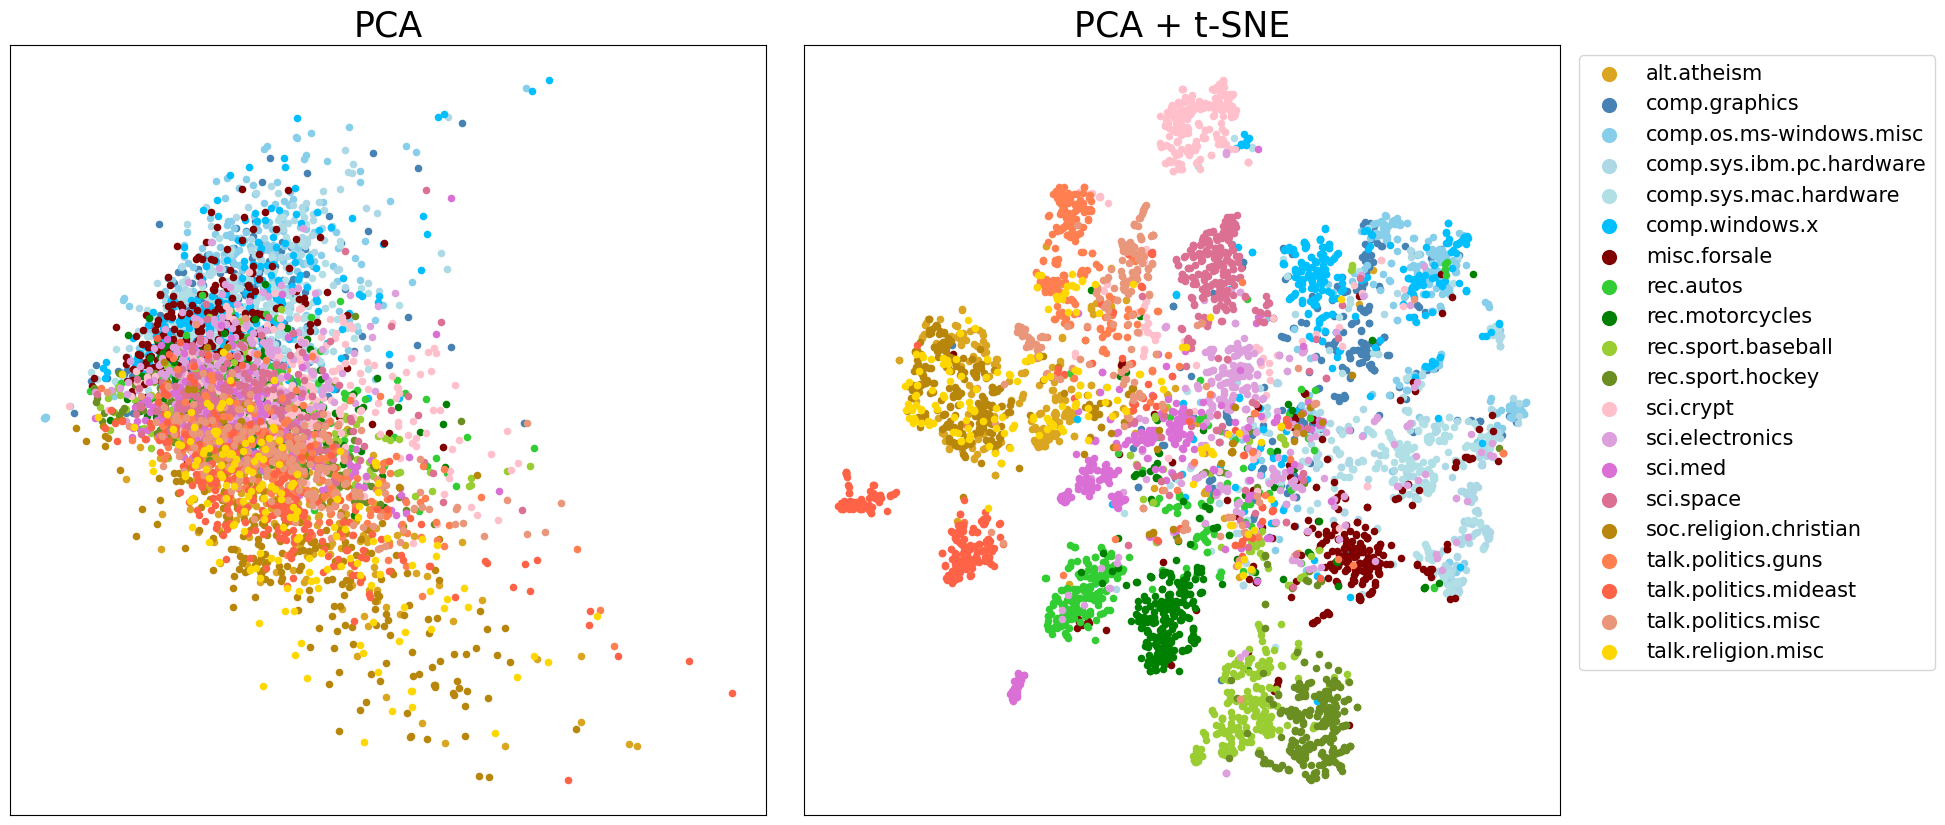

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for t in targets:
    t_df = zeta_df[zeta_df['target'] == t]
    ax[0].scatter(t_df[0], t_df[1], marker='o', edgecolor='black',
                  linewidth=0, s=30, label=t, c=target_colour[t])
ax[0].set_title(f'PCA', fontsize=25)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)

for t in targets:
    t_df = tsne_zeta_df[tsne_zeta_df['target'] == t]
    ax[1].scatter(t_df[0], t_df[1], marker='o', edgecolor='black',
                  linewidth=0, s=30, label=t, alpha=1, c=target_colour[t])
ax[1].set_title(f'PCA + t-SNE', fontsize=25)
ax[1].legend(loc='upper right', bbox_to_anchor=(
    1.51, 1), prop={'size': 15}, markerscale=2)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0)

# functions

In [60]:
import numpy as np
import networkx as nx
from sklearn.cluster import AgglomerativeClustering



## ===== dot product agglomerative clustering

class DotProductAgglomerativeClustering:
    """ 
    Perform hierarchical clustering using dot product as the metric.    
    
    Parameters: 
    ----------  
    metric : str, optional  
        The metric to use for clustering.   
    linkage : str, optional 
        The linkage criterion to use.
    distance_threshold : float, optional    
        The linkage distance threshold above which, clusters will not be merged.
    n_clusters : int, optional  
        The number of clusters to find.
        
    Attributes: 
    ----------  
    distances_ : ndarray    
        The distances between the clusters. 
    children_ : ndarray 
        The children of each non-leaf node.
    labels_ : ndarray   
        The labels of each point.
    n_clusters_ : int   
        The number of clusters.
    n_connected_components_ : int   
        The number of connected components. 
    n_leaves_ : int 
        The number of leaves.
    n_features_in_ : int    
        The number of features seen during fit.
    n_clusters_ : int   
        The number of clusters.
    """
    def __init__(self, metric='dot_product', linkage='average', distance_threshold=0, n_clusters=None):
        self.metric = metric
        self.linkage = linkage
        self.distance_threshold = distance_threshold
        self.n_clusters = n_clusters
        self.model = None
        

    def fit(self, X):
        model = AgglomerativeClustering(
            metric=self._ip_metric if self.metric == 'dot_product' else self.metric,
            linkage=self.linkage,
            distance_threshold=self.distance_threshold,
            n_clusters=self.n_clusters
        )
        model.fit(X)
        
        # If distances_ attribute is available, adjust it as specified
        if hasattr(model, 'distances_'):
            self.distances_ = -model.distances_
        if hasattr(model, 'distances_'):
            self.children_ = model.children_
        if hasattr(model, 'labels_'):
            self.labels_ = model.labels_    
        if hasattr(model, 'n_clusters_'):
            self.n_clusters_ = model.n_clusters_
        if hasattr(model, 'n_connected_components_'):   
            self.n_connected_components_ = model.n_connected_components_    
        if hasattr(model, 'n_leaves_'): 
            self.n_leaves_ = model.n_leaves_    
        if hasattr(model, 'n_features_in_'):    
            self.n_features_in_ = model.n_features_in_  
        if hasattr(model, 'n_clusters_'):   
            self.n_clusters_ = model.n_clusters_    
        
        self = model
        return self

    @staticmethod
    def _ip_metric(X):
        return -(X @ X.T)

## === cophenetic distane function

def _is_visited(visited, idx):
    byte = visited[idx >> 3]
    return (byte & (1 << (idx & 7))) != 0

def _set_visited(visited, idx):
    visited[idx >> 3] |= (1 << (idx & 7))

def cophenetic_distances(Z):
    """
    Calculate the cophenetic distances between each observation and internal nodes.

    Parameters
    ----------
    Z : ndarray
        The linkage matrix.

    Returns
    -------
    d : ndarray
        The full distance matrix (2n-1) x (2n-1).
    """
    n = Z.shape[0] + 1
    N = 2 * n - 1
    d = np.zeros((N, N))
    curr_node = np.zeros(n, dtype=int)
    members = np.zeros(n, dtype=int)
    left_start = np.zeros(n, dtype=int)

    visited_size = ((N >> 3) + 1)
    visited = np.zeros(visited_size, dtype=np.uint8)

    k = 0
    curr_node[0] = 2 * n - 2
    left_start[0] = 0
    while k >= 0:
        root = curr_node[k] - n
        i_lc = int(Z[root, 0])
        i_rc = int(Z[root, 1])

        if i_lc >= n:  # left child is not a leaf
            n_lc = int(Z[i_lc - n, 3])
            if not _is_visited(visited, i_lc):
                _set_visited(visited, i_lc)
                k += 1
                curr_node[k] = i_lc
                left_start[k] = left_start[k - 1]
                continue  # visit the left subtree
        else:
            n_lc = 1
            members[left_start[k]] = i_lc

        if i_rc >= n:  # right child is not a leaf
            n_rc = int(Z[i_rc - n, 3])
            if not _is_visited(visited, i_rc):
                _set_visited(visited, i_rc)
                k += 1
                curr_node[k] = i_rc
                left_start[k] = left_start[k - 1] + n_lc
                continue  # visit the right subtree
        else:
            n_rc = 1
            members[left_start[k] + n_lc] = i_rc

        # back to the root of current subtree
        dist = Z[root, 2]
        right_start = left_start[k] + n_lc

        # Update distances for leaf nodes in left and right children
        for i in range(left_start[k], right_start):
            for j in range(right_start, right_start + n_rc):
                d[members[i], members[j]] = dist
                d[members[j], members[i]] = dist

        # Update distances for internal nodes
        all_members = members[left_start[k]:right_start + n_rc]
        for i in all_members:
            d[root + n, i] = dist
            d[i, root + n] = dist

        # Add distance between the root of the current subtree and its parent
        if k > 0:
            parent = curr_node[k - 1] - n
            parent_dist = Z[parent, 2]
            d[root + n, parent + n] = parent_dist
            d[parent + n, root + n] = parent_dist

        k -= 1  # back to parent node

    return d


## === Calculate branch lengths 

def linkage_matrix(model):
    """ 
    Convert a hierarchical clustering model to a linkage matrix.    
    
    Parameters: 
    ----------  
    model : AgglomerativeClustering
        The fitted model.   
    get_heights : bool, optional    
        Whether to return heights or counts.
    max_height : float, optional    
        The maximum height of the tree.
        
    Returns:    
    ------- 
    ndarray
        The linkage matrix.
    """ 
    counts = np.zeros(model.children_.shape[0])
    n_samples = model.children_.shape[0] + 1
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    linkage_matrix[:,:2] = linkage_matrix[:,:2].astype(int)

    return linkage_matrix

def branch_lengths(Z, point_cloud):
    """
    Calculate branch lengths for a hierarchical clustering dendrogram.

    Parameters:
    ----------
    Z (ndarray): The linkage matrix.
    point_cloud (ndarray): The data points.

    Returns:
    -------
    ndarray: Matrix of branch lengths.
    """
    n = point_cloud.shape[0]
    N = 2*n-1

    heights = np.hstack([np.linalg.norm(point_cloud,axis=1) ** 2, Z[:,2]])
    merge_heights = cophenetic_distances(Z)

    B = np.repeat(heights, N).reshape(N, N) + np.repeat(heights, N).reshape(N,N).T - 2*merge_heights
    B = np.abs(B)
    B[merge_heights == 0] = -np.inf

    return B

## === Find node descendants 


def find_descendents(Z, node, desc=None, just_leaves=True):
    """
    Find all descendants of a given node in a hierarchical clustering tree.

    Parameters:
    ----------
    Z (ndarray): The linkage matrix.
    node (int): The node to find descendants of.
    desc (dict, optional): Dictionary to store descendants.
    just_leaves (bool, optional): Whether to include only leaf nodes.

    Returns:
    -------
    list: List of descendants.
    """
    if desc is None:
        desc = {}
    n_samples = Z.shape[0] + 1
    if node in desc:
        return desc[node]
    if node < n_samples:
        return [node]
    pair = Z[node - n_samples, :2].astype(int)
    if just_leaves: 
        desc[node] = find_descendents(Z, pair[0], desc) + find_descendents(Z, pair[1], desc)
    else:
        desc[node] = [int(pair[0])] + [int(pair[1])] + find_descendents(Z, pair[0], desc) + find_descendents(Z, pair[1], desc)
    return desc[node]


## === Create new graph

def _epsilon_tree(Z, B, epsilon = 0.25):
    """
    Condense a hierarchical clustering tree.

    Parameters:
    ----------
    Z (ndarray): The linkage matrix.
    B (ndarray): Matrix of branch lengths.
    epsilon (float): Threshold for condensing the tree.

    Returns:
    -------
    nx.Graph: Condensed tree as a NetworkX graph.
    """
    n = Z.shape[0] + 1
    N = 2*n-1
    G = nx.Graph()

    reverse_lm = Z[::-1] 

    internal_nodes = sorted(range(n, n + reverse_lm.shape[0]), reverse=True)
    internal_nodes_set = set(internal_nodes)

    desc = {i: find_descendents(Z, i) for i in range(n, 2 * n - 1)}

    desc[N-1] = list(range(N))
    for idx in internal_nodes:
        i = N - idx - 1
        merge = reverse_lm[i]
        left = int(merge[0])
        right = int(merge[1])
        
        left_desc = desc[left] if left >= n else [left]
        right_desc = desc[right] if right >= n else [right]
        
        if np.any(B[idx, left_desc] > epsilon):
            G.add_edge(idx, left, len=B[idx, left])
        else:
            internal_nodes_set.difference_update([left] + left_desc)
        
        if np.any(B[idx, right_desc] > epsilon):
            G.add_edge(idx, right, len=B[idx, right])
        else:
            internal_nodes_set.difference_update([right] + right_desc)
        
        # Update the list after potential changes
        internal_nodes = sorted(internal_nodes_set, reverse=True)
        
    return G


def condense_tree(data, metric = 'dot_product', linkage = 'average', epsilon = 0.25):
    """ 
    Condense a hierarchical clustering tree.    

    """

    Z = linkage_matrix(model)
    B = branch_lengths(Z, data)
    G = _epsilon_tree(Z, B, epsilon = epsilon)
    return G
    
G = condense_tree(zeta, epsilon = 0) 
print(f'number of nodes: {G.number_of_nodes()}')


number of nodes: 9999


In [ ]:
model = DotProductAgglomerativeClustering(metric = metric, linkage = linkage)
model.fit(zeta);

G = condense_tree(zeta, epsilon = 0) 
print(f'number of nodes: {G.number_of_nodes()}')


## Hierarchical clustering

Here, we agglomerative clustering with dot products [^2].

First we do this for the centroids of each topic and plot the dendrogram. Then we do HC on the whole dataset and visualise the output tree. 

In [15]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

def ip_metric(X, Y):
    return np.sum(X * Y)


def dp_affinity(X):
    ips = pairwise_distances(X, metric=ip_metric)
    return np.max(ips) - ips

Find the centroids

In [16]:
idxs = [np.where(np.array(df['target']) == t)[0]
        for t in sorted(df['target'].unique())]
t_zeta = np.array([np.mean(zeta[idx, :], axis=0) for idx in idxs])
t_Y = np.array([np.mean(Y[idx, :],axis = 0) for idx in idxs]).reshape(len(sorted(df['target'].unique())),p)

Topic HC clustering

In [17]:
t_dp_clust = AgglomerativeClustering(
    metric=dp_affinity, linkage='average', distance_threshold=0, compute_distances=True, n_clusters=None)
t_dp_clust = t_dp_clust.fit(t_zeta)

Plot dendrogram

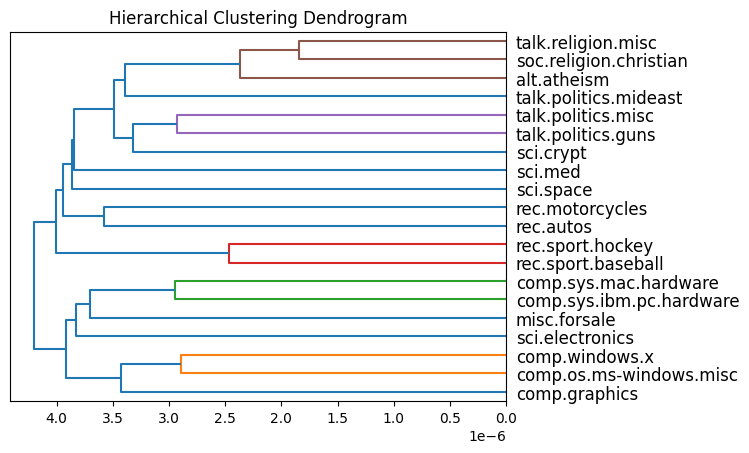

In [18]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
rs.plot_dendrogram(t_dp_clust, orientation='left',
                   labels=sorted(df['target_names'].unique()))
plt.show()

Individual document HC clustering

In [19]:
dp_clust = AgglomerativeClustering(
    metric=dp_affinity, linkage='average', distance_threshold=0, compute_distances=True, n_clusters=None)
dp_clust = dp_clust.fit(zeta)

Plot tree

In [20]:
colours = [target_colour[label] for label in list(df["target_names"])]

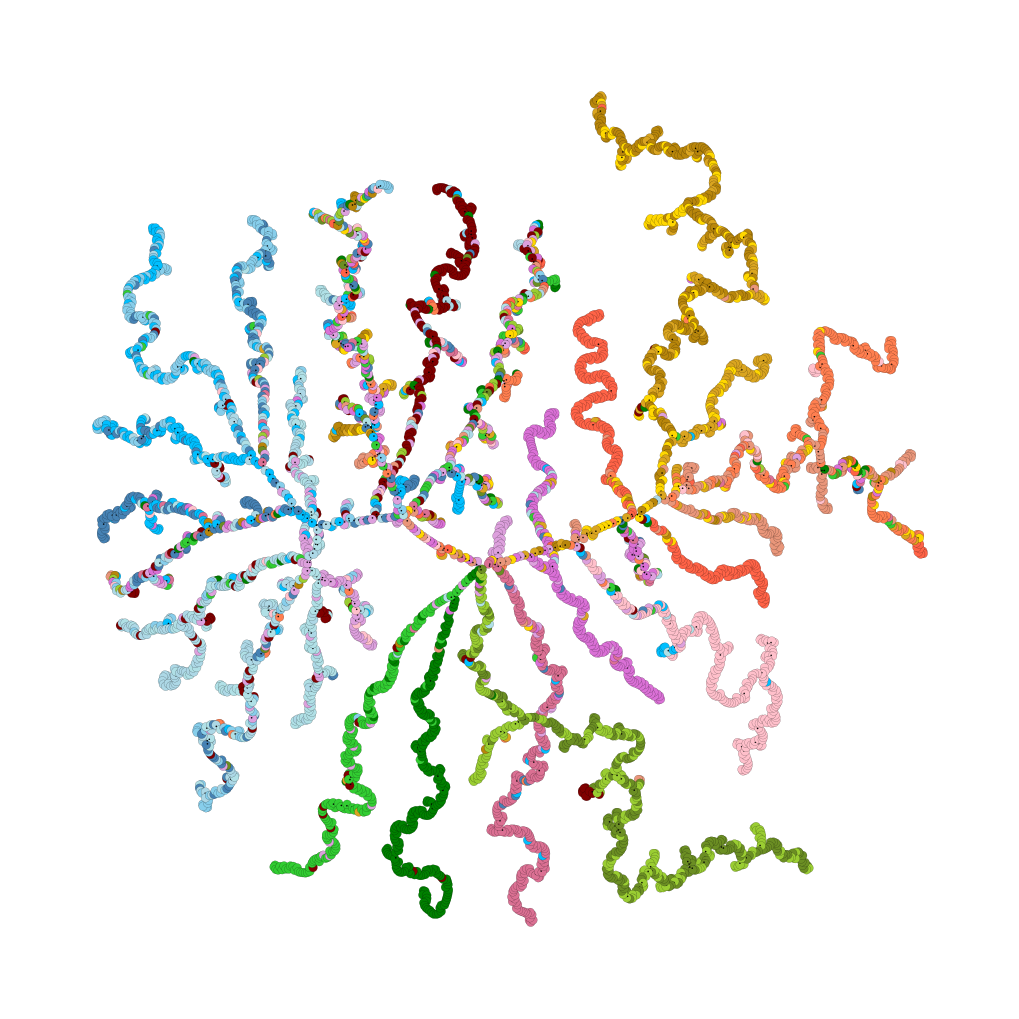

In [21]:
rs.plot_HC_clustering(dp_clust, node_colours=colours, internal_node_colour='black', linewidths=.1,
                      edgecolors='black', leaf_node_size=40, fontsize=10, internal_node_size=1, figsize=(10, 7.5
                                                                                                         ))

## References


[^1]: Whiteley, N., Gray, A. and Rubin-Delanchy, P., 2022. Statistical exploration of the Manifold Hypothesis. arXiv preprint arXiv:2208.11665.

[^2]: Gray, A., Modell, A., Rubin-Delanchy, P. and Whiteley, N., 2024. Hierarchical clustering with dot products recovers hidden tree structure. Advances in Neural Information Processing Systems, 36.